# 🤗 Welcome to AdalFlow!
## The library to build & auto-optimize any LLM task pipelines

Thanks for trying us out, we're here to provide you with the best LLM application development experience you can dream of 😊 any questions or concerns you may have, [come talk to us on discord,](https://discord.gg/ezzszrRZvT) we're always here to help! ⭐ <i>Star us on <a href="https://github.com/SylphAI-Inc/AdalFlow">Github</a> </i> ⭐


# Quick Links

Github repo: https://github.com/SylphAI-Inc/AdalFlow

Full Tutorials: https://adalflow.sylph.ai/index.html#.

Deep dive on each API: check out the [developer notes](https://adalflow.sylph.ai/tutorials/index.html).

Common use cases along with the auto-optimization:  check out [Use cases](https://adalflow.sylph.ai/use_cases/index.html).

# Author

This notebook was created by [Li Yin]().

# Outline

This is a quick introduction of what AdalFlow is capable of. We will cover:

* Build a standard RAG.
* Evaluate the RAG performance with HotpotQA dataset using deepseek and gpt model series.
* Auto-optimize the RAG with the HotpotQA dataset.



# Installation

1. Use `pip` to install the `adalflow` Python package. We will need `openai` and `together` from the extra packages.

  ```bash
  pip install adalflow[openai,together]
  ```
2. Setup  `openai` and `groq` API key in the environment variables

In [1]:
from IPython.display import clear_output

!pip install -U adalflow[openai,together]

clear_output()

## Set Environment Variables

Run the following code and pass your api key.

Note: for normal `.py` projects, follow our [official installation guide](https://lightrag.sylph.ai/get_started/installation.html).

*Go to [OpenAI](https://platform.openai.com/docs/introduction) and [Together](https://www.together.ai/) to get API keys if you don't already have.*

In [2]:
import os

from getpass import getpass


OPENAI_API_KEY = getpass("Please enter your OpenAI API key: ")
TOGETHER_API_KEY = getpass("Please enter your Together API key: ")


os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY

print("API keys have been set.")

API keys have been set.


# 😇 Build the RAG

We will use DsPy's retriever in this demonstration to retrieve relevant documents from wikipedia. We will wrap it into AdalFlow's retriever api and use AdalFlow's generator to generate the answer.

In [3]:
!pip install dspy
clear_output()

In [4]:
# wrap the retriever

import adalflow as adal
from adalflow.core.types import RetrieverOutput
import dspy
from typing import Optional

colbertv2_wiki17_abstracts = dspy.ColBERTv2(
    url="http://20.102.90.50:2017/wiki17_abstracts"
)

dspy.settings.configure(rm=colbertv2_wiki17_abstracts)


class DspyRetriever(adal.Retriever):
    def __init__(self, top_k: int = 3):
        super().__init__()
        self.top_k = top_k
        self.dspy_retriever = dspy.Retrieve(k=top_k)

    def call(
        self, input: str, top_k: Optional[int] = None, id: str = None
    ) -> RetrieverOutput:

        k = top_k or self.top_k

        if not input:
            raise ValueError(f"Input cannot be empty, top_k: {k}")

        output = self.dspy_retriever(query=input, k=k)
        # print(f"dsy_retriever output: {output}")
        documents = output.passages

        return RetrieverOutput(
            query=input,
            documents=documents,
            doc_indices=[],
        )

/Users/liyin/Documents/test/LightRAG/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [5]:
from dataclasses import dataclass, field
from typing import Union


# output data class
@dataclass
class AnswerData(adal.DataClass):
    reasoning: str = field(
        metadata={"desc": "The reasoning to produce the answer"},
    )
    answer: str = field(
        metadata={"desc": "The answer you produced"},
    )

    __output_fields__ = ["reasoning", "answer"]


# prompt
task_desc_str = r"""Answer questions with short factoid answers.

You will receive context(contain relevant facts).
Think step by step."""

answer_template = """<START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
"""


class VanillaRAG(adal.Component):
    def __init__(self, passages_per_hop=3, model_client=None, model_kwargs=None):
        super().__init__()

        self.passages_per_hop = passages_per_hop

        self.retriever = DspyRetriever(top_k=passages_per_hop)
        self.llm_parser = adal.DataClassParser(
            data_class=AnswerData, return_data_class=True, format_type="json"
        )
        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs={
                "task_desc_str": adal.Parameter(
                    data=task_desc_str,
                    role_desc="""Task description for the language model,\
                    used with the following template: \
                    {{task_desc_str}} \
                    {{output_format_str}}\
                    <START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>""",
                    param_type=adal.ParameterType.PROMPT,
                    requires_opt=True,
                    instruction_to_backward_engine="You need find the best way(where does the right answer come from the context) to extract the RIGHT answer from the context.",
                    instruction_to_optimizer="You need find the best way(where does the right answer come from the context) to extract the RIGHT answer from the context.",
                ),
                "output_format_str": self.llm_parser.get_output_format_str(),
            },
            template=answer_template,
            output_processors=self.llm_parser,
            use_cache=True,
        )

    def bicall(
        self, question: str, id: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """This function is used to call the model for both training and eval mode."""
        retriever_out = self.retriever(input=question)
        retrieved_context = None
        if isinstance(retriever_out, adal.Parameter):
            successor_map_fn = lambda x: (  # noqa E731
                "\n\n".join(x.data.documents)
                if x.data and x.data and x.data.documents
                else ""
            )
            retriever_out.add_successor_map_fn(
                successor=self.llm, map_fn=successor_map_fn
            )
        else:
            successor_map_fn = lambda x: (  # noqa E731
                "\n\n".join(x.documents) if x and x.documents else ""
            )
            retrieved_context = successor_map_fn(retriever_out)
        prompt_kwargs = {
            "context": retrieved_context,
            "question": question,
        }
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

In [6]:
# all models options
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.components.model_client.together_client import TogetherClient


gpt_3_model = {
    "model_client": OpenAIClient(input_type="text"),
    "model_kwargs": {
        "model": "gpt-3.5-turbo-0125",
        "max_tokens": 2000,
        "temperature": 0.0,
        "top_p": 0.99,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "stop": None,
    },
}

gpt_o1_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "o1",
        "temperature": 1,
        # "top_p": 0.99,
    },
}

gpt_o3_mini_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "o3-mini",
        "temperature": 1,
        # "top_p": 0.99,
    },
}

gpt_4o_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "gpt-4o",
        "temperature": 1,
        "top_p": 0.99,
    },
}

deepseek_r1_model = {
    "model_client": TogetherClient(),
    "model_kwargs": {
        "model": "deepseek-ai/DeepSeek-R1",
        "temperature": 1,
        "top_p": 0.99,
    },
}

deepseek_r1_distilled_model = {
    "model_client": TogetherClient(),
    "model_kwargs": {
        "model": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
        "temperature": 1,
        "top_p": 0.99,
    },
}

In [7]:
rag = VanillaRAG(**gpt_o1_model)

query = "Who is Shakespear?"

output = rag.bicall(query)
print(output)
output.data

GeneratorOutput(id=None, data=AnswerData(reasoning='The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).', answer='They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear.'), error=None, usage=CompletionUsage(completion_tokens=615, prompt_tokens=346, total_tokens=961), raw_response='```\n{\n    "reasoning": "The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).",\n    "answer": "They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear."\n}\n```', metadata=None)


AnswerData(reasoning='The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).', answer='They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear.')

In [8]:
# check the dataset
from adalflow.datasets.hotpot_qa import HotPotQA


def load_datasets():

    trainset = HotPotQA(split="train", size=100)  # 20
    valset = HotPotQA(split="val", size=100)  # 50
    testset = HotPotQA(split="test", size=200)  # to keep the same as the dspy #50
    print(f"trainset, valset: {len(trainset)}, {len(valset)}, example: {trainset[0]}")
    return trainset, valset, testset

In [9]:
trainset, valset, testset = load_datasets()
trainset[0]

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pacific convergence zone as a small tropical depression on November 13, to the northeast of the Solomon Islands.', ' Over the next few days the system gradually developed further within an area of light winds in the upper troposphere, before it was named Tia early on November 16.', ' Later that

In [10]:
# test on one using gpt o1 and deepseek r1

rag_o1 = VanillaRAG(**gpt_o1_model)
rag_deepseek_r1 = VanillaRAG(**deepseek_r1_model)

query = trainset[0].question
output_o1 = rag_o1.bicall(query)
output_deepseek_r1 = rag_deepseek_r1.bicall(query)

print(f"query: {query}")
print(f"output_o1: {output_o1.data}")
print(f"output_deepseek_r1: {output_deepseek_r1.data}")
print(f"answer: {trainset[0].answer}")

query: Which host of Whodunnit died on November 16, 2009?
output_o1: AnswerData(reasoning='Edward Woodward died on 16 November 2009.', answer='Edward Woodward')
output_deepseek_r1: AnswerData(reasoning="The question asks which host of 'Whodunnit?' died on November 16, 2009. From the context, the UK series (1973–1978) had hosts Edward Woodward (1973) and Jon Pertwee (1974–1978). The US version (1979) was hosted by Ed McMahon. Jon Pertwee died in 1996, Ed McMahon in 2009 (June 23), and Edward Woodward died on November 16, 2009, making him the correct answer.", answer='Edward Woodward')
answer: Edward Woodward


## AdalComponent to manage training and evaluation

In [11]:
from adalflow.eval.answer_match_acc import AnswerMatchAcc
from adalflow.datasets.types import HotPotQAData

from typing import Dict, Tuple, Callable, Any


class HotPotQAAdal(adal.AdalComponent):
    def __init__(
        self,
        backward_engine_model_config: Dict | None = None,
        teacher_model_config: Dict | None = None,
        text_optimizer_model_config: Dict | None = None,
        task: adal.Component | None = None,  # initialized task
    ):

        eval_fn = AnswerMatchAcc(type="exact_match").compute_single_item
        loss_eval_fn = AnswerMatchAcc(type="f1_score").compute_single_item

        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=loss_eval_fn,
            eval_fn_desc="exact_match: 1 if str(y_gt) == str(y) else 0",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_eval_fn=loss_eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            teacher_model_config=teacher_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
        )

    def prepare_task(self, sample: HotPotQAData) -> Tuple[Callable[..., Any], Dict]:
        if self.task.training:
            return self.task.forward, {"question": sample.question, "id": sample.id}
        else:
            return self.task.call, {"question": sample.question, "id": sample.id}

    def prepare_eval(self, sample: HotPotQAData, y_pred: adal.GeneratorOutput) -> float:
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer  # .lower()
        # printc(f"y_label: {y_label}, y_gt: {sample.answer}")
        return self.eval_fn, {"y": y_label, "y_gt": sample.answer}

    def prepare_loss_eval(self, sample: Any, y_pred: Any, *args, **kwargs) -> float:
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer
        return self.loss_eval_fn, {"y": y_label, "y_gt": sample.answer}

    def prepare_loss(self, sample: HotPotQAData, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.answer,
            eval_input=sample.answer,
            requires_opt=False,
        )

        pred.eval_input = (
            pred.data.data.answer
            if pred.data and pred.data.data and pred.data.data.answer
            else ""
        )
        # TODO: understand better of the goal of gt and input
        return self.loss_fn, {
            "kwargs": {"y": pred, "y_gt": y_gt},
            "input": {"question": sample.question},
            "gt": sample.answer,
            "id": sample.id,
        }

### Evaluation only

In [20]:
def train_diagnose(model_client, model_kwargs):

    _, _, testset = load_datasets()

    task = VanillaRAG(
        model_client=model_client,
        model_kwargs=model_kwargs,
        passages_per_hop=3,
    )

    adal_component = HotPotQAAdal(
        task=task,
    )
    trainer = adal.Trainer(adaltask=adal_component)
    trainer.diagnose(dataset=testset, split="train")

In [21]:
train_diagnose(**gpt_o1_model)  # 2m11s without cache #57% on trainm 49% on test

NameError: name 'gpt_o1_model' is not defined

In [57]:
# train_diagnose(**deepseek_r1_model)  # 34m 226s without cache #46%

# r1 have some structure format issue.and it seems together hosting is slow

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl
Loading Data: 100%|██████████| 200/200 [00:00<00:00, 86542.95it/s]
Predicting: step(0): 1.0 across 1 samples, Max potential: 1.0:   0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
train_diagnose(**deepseek_r1_distilled_model)  # 41% 2m19.1s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 84400.93it/s]
Predicting: step(0): 0.1818 across 11 samples, Max potential: 0.955:   5%|▌         | 10/200 [00:17<07:19,  2.31s/it]Error at parsing output: Error: No JSON object or array found in the text: <think>
Okay, so I need to figure out which comic book was also written by the writer of Crossed. Let's start by looking at the context provided. 

First, there are three different entries here: Crossed (comics), Crossed (novel), and Star Crossed (comics). 

The question is about the comic book written by the same writer as Crossed. So I'm focusing on Crossed (comics), which is written by Garth Ennis, and then later by David Lapham for some volumes. 

Now, looking at the other entries, Star Crossed is a comic book mini-series written by Matt Howarth. Crossed (novel) is written by Allyson Braithwaite Condie.

Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.41
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [59]:
train_diagnose(**gpt_o3_mini_model)  # 56%, 1m58s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 34388.00it/s]
Predicting: step(0): 0.56 across 100 samples, Max potential: 0.56: 100%|██████████| 100/100 [00:00<00:00, 183.70it/s]
Error loading jsonl file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl: line contains invalid json: unexpected content after document: line 1 column 8686 (char 8685) (line 114)


Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.56
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [14]:
train_diagnose(**gpt_3_model)  # 42% 25s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 92681.56it/s]
Predicting: step(0): 0.395 across 200 samples, Max potential: 0.395: 100%|██████████| 200/200 [00:00<00:00, 432.60it/s] 
Error loading jsonl file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl: line contains invalid json: unexpected content after document: line 1 column 8686 (char 8685) (line 114)


Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.40
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




Here is the current performance on the tested modeles:

**Train dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 57 | 2m12s |  |
| o3mini  | 56 | 1m58s |  |
| gpt3.5 | 42 | 25s | |
| r1  | 46 | 34m | structure data format errors, the <br> running time might because of the <br> deployment rather than the model itself |
| r1 distilled  | 41 | 2m19s | structure data format errors |

**Test dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 49 | N/A |  |
| gpt3.5 | 40 |  | |
| r1 distilled  | 41.5 |  | structure data format errors |

# Training.

First, we will try to use cheaper models to do the same task with lower cost.
Let's train gpt3.5 with o3-mini first as o3-mini is the cheapest among 4o, o1.

In [23]:
from adalflow.core.generator import BackwardPassSetup


def train(
    task_model_cliet,
    task_model_kwargs,
    optimizer_model_config,
    backward_engine_model_config,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 4,
    max_steps=1,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
    resume_from_ckpt=None,
    exclude_input_fields_from_bootstrap_demos=True,
    seed=None,
    max_proposals_per_step: int = 5,
    disable_backward_gradients: bool = False,
    disable_backward: bool = False,
):
    task = VanillaRAG(
        model_client=task_model_cliet,
        model_kwargs=task_model_kwargs,
        passages_per_hop=3,
    )

    adal_component = HotPotQAAdal(
        task=task,
        text_optimizer_model_config=optimizer_model_config,
        backward_engine_model_config=backward_engine_model_config,
    )

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        adaltask=adal_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=False,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=exclude_input_fields_from_bootstrap_demos,
        max_proposals_per_step=max_proposals_per_step,
        text_optimizers_config_kwargs={"max_past_history": 5},
        disable_backward_gradients=disable_backward_gradients,
        disable_backward=disable_backward,
    )
    trainer.set_random_seed(seed)
    print(trainer)

    train_dataset, val_dataset, test_dataset = load_datasets()
    ckpt, _ = trainer.fit(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        resume_from_ckpt=resume_from_ckpt,
    )
    return ckpt

In [24]:
train(
    task_model_cliet=gpt_3_model["model_client"],
    task_model_kwargs=gpt_3_model["model_kwargs"],
    optimizer_model_config=gpt_o3_mini_model,
    backward_engine_model_config=gpt_o3_mini_model,
    max_steps=12,
)

NameError: name 'gpt_3_model' is not defined

In [10]:
# write code to plot the training curve

file = (
    "/Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json"
)

In [11]:
import json
import matplotlib.pyplot as plt


def plot_single_training(
    file_path,
    model_name,
    marker_val="o",
    color_val="tab:blue",
    marker_test="D",
    color_init_test="tab:orange",
    color_final_test="tab:green",
):
    """
    Plots the training progression (validation curve, initial test score, and
    final test score) for a single model.

    Parameters:
    -----------
    file_path : str
        Path to the JSON file containing the training data.
    model_name : str
        Label to use in the legend for this model.
    marker_val : str
        Marker style for validation scores.
    color_val : str
        Color for validation scores line.
    marker_test : str
        Marker style for test scores.
    color_init_test : str
        Color for the initial test score.
    color_final_test : str
        Color for the final test score.
    """
    with open(file_path, "r") as f:
        data = json.load(f)

    val_scores = data.get("val_scores", [])
    start_test_score = data.get("test_scores", [None])[0]
    end_test_score = data.get("test_score", None)

    # Plot validation scores
    plt.plot(
        val_scores,
        label=f"{model_name} - Validation",
        marker=marker_val,
        markersize=5,
        linewidth=1.5,
        color=color_val,
    )

    # Plot initial test score
    if start_test_score is not None:
        plt.scatter(
            0,
            start_test_score,
            s=100,
            marker=marker_test,
            color=color_init_test,
            edgecolor="black",
            label=f"{model_name} - Initial Test",
        )

    # Plot final test score
    if end_test_score is not None and len(val_scores) > 0:
        plt.scatter(
            len(val_scores) - 1,
            end_test_score,
            s=100,
            marker=marker_test,
            color=color_final_test,
            edgecolor="black",
            label=f"{model_name} - Final Test",
        )


def compare_two_trainings(file1, model1, file2, model2):
    """
    Creates a single figure that compares the training progression of two models.
    Calls `plot_single_training` for each model and overlays the plots.

    Parameters:
    -----------
    file1 : str
        Path to the JSON file for the first model.
    model1 : str
        Name/label for the first model.
    file2 : str
        Path to the JSON file for the second model.
    model2 : str
        Name/label for the second model.
    """
    plt.figure(figsize=(12, 6))

    # Plot the first model
    plot_single_training(
        file1,
        model1,
        marker_val="o",
        color_val="tab:blue",
        marker_test="D",
        color_init_test="tab:orange",
        color_final_test="tab:green",
    )

    # Plot the second model
    plot_single_training(
        file2,
        model2,
        marker_val="s",
        color_val="tab:red",
        marker_test="^",
        color_init_test="tab:purple",
        color_final_test="tab:brown",
    )

    plt.title("Comparison of Model Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Score", fontsize=12)

    # Combine legend entries from both plots
    plt.legend(loc="lower right", frameon=True)

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_training_single(file):
    import json
    import matplotlib.pyplot as plt

    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores) - 1,
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()

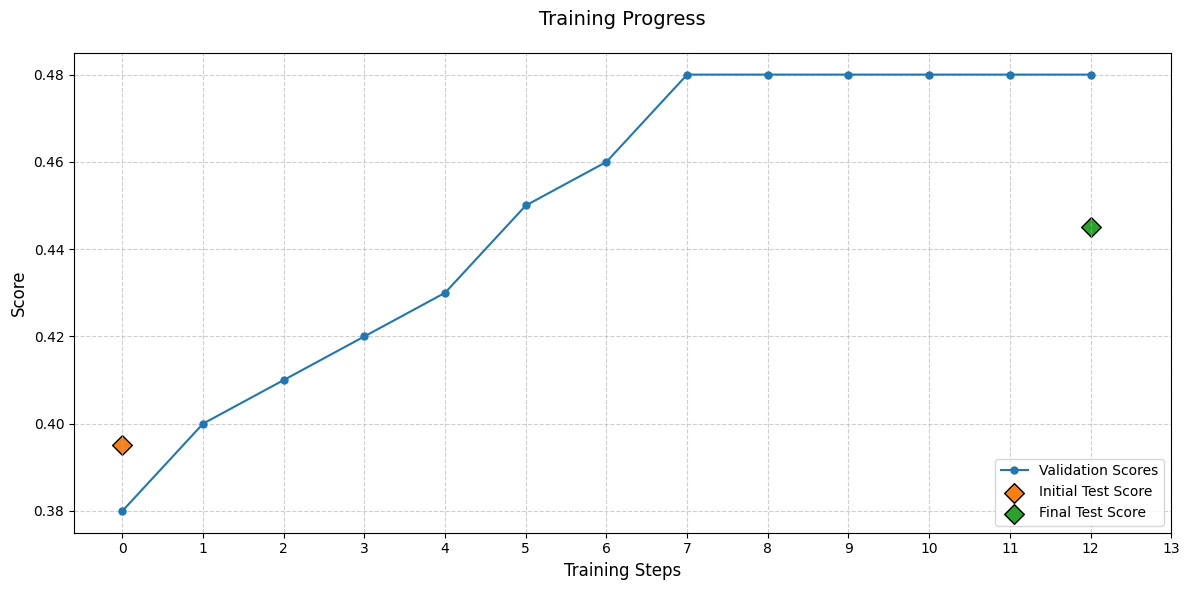

In [ ]:
plot_training_single(file)

In [14]:
# now use the opensource distill model
train(
    task_model_cliet=deepseek_r1_distilled_model["model_client"],
    task_model_kwargs=deepseek_r1_distilled_model["model_kwargs"],
    optimizer_model_config=gpt_o3_mini_model,
    backward_engine_model_config=gpt_o3_mini_model,
    max_steps=12,
)

NameError: name 'train' is not defined

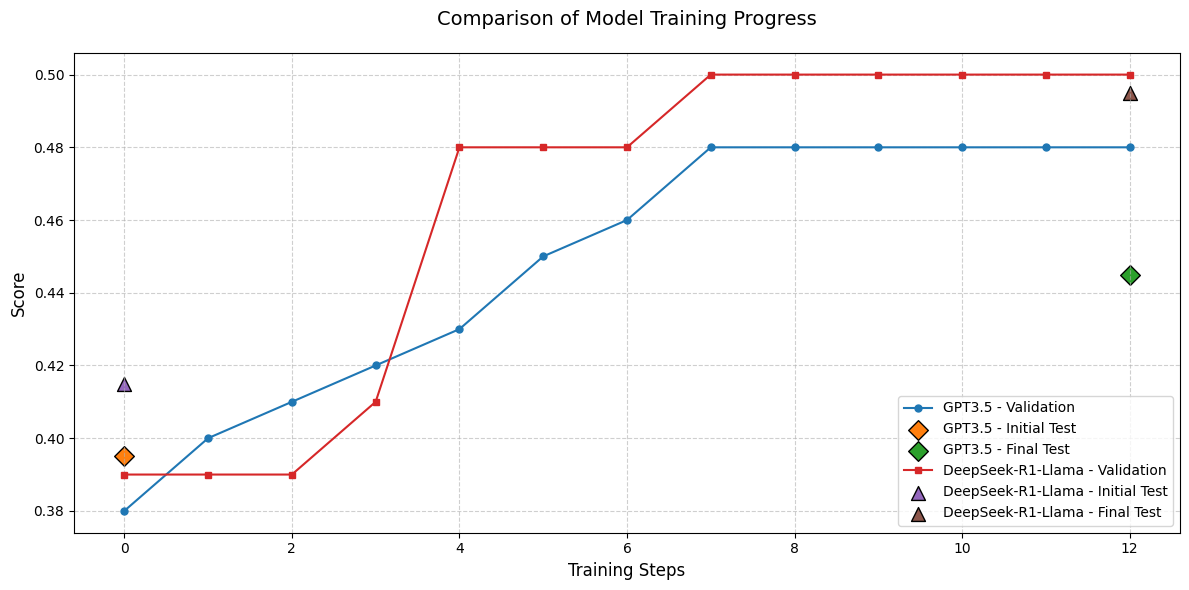

In [ ]:
file2 = (
    "/Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_77514_run_1.json"
)
# plot_training(file2)

compare_two_trainings(
    file1=file, model1="GPT3.5", file2=file2, model2="DeepSeek-R1-Llama"
)

**Test dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 49 | N/A |  |
| o3 mini | N/A |  | |
| gpt3.5 | 39.5 |  | |
| r1 distilled  | 41.5 |  | structure data format errors |
| gpt3.5 trained | 44.5 |  | |
| r1 distilled trained |49.5|  | |

# 🤗  Experiments conclusion


1. A trained DeepSeek R1 LLaMA70B(r1 distilled) is even better than GPT-o1 without training.
2. The “Reasoning” model is less susceptible to overfitting compared with non-reasoning models. By comparing it with GPT-3.5, both gpt3.5 and r1 distilled start at the same accuracy and reach similar accuracy on the validation dataset. However, on the test dataset, r1 distilled often achieves much higher accuracy.
3. R1 can think too long and run out of output tokens before finishing the task. The optimized prompt specifically added instructions for it to “think less.”



GPT3.5 trained final prompt:

"data": "Answer questions with short factoid answers. Extract the authoritative answer exactly as it appears in the provided context or, if the context is missing or ambiguous, only after a rigorous cross-validation process. In such cases, you MUST consult at least two verified external records and continue to search until a consensus is reached on the precise answer. Do not rely on local inferences or substitute synonyms. Ensure that the final answer exactly matches the verified source, including matching the exact wording, case, punctuation, and any qualifiers (e.g. 'American' before 'football'). Follow these steps:\n\n1. Identify all relevant phrases from the provided context or from the verified external records.\n2. Cross-check at least two reliable sources to confirm the authoritative fact.\n3. If multiple sources disagree, continue verification until a consensus is reached.\n4. Output the final answer exactly as specified by the verified source, without any modifications.\n\nFor example, if external records confirm that the correct answer is 'Edward Woodward' for a missing context query on a host, output 'Edward Woodward' exactly; for another query, if the precise verified answer is 'University of Oregon', output 'University of Oregon' exactly; and for a query about 'Bo Knows Bo', ensure the complete verified answer 'baseball and American football' is returned verbatim.",

DeepSeek r1 distilled trained final prompt:

value: Answer questions with short factoid responses. You will receive context (with
  relevant facts) and a question. Internally compute the correct answer using hidden,
  rapid reasoning and provide only the final answer exactly matching the ground truth
  with no additional commentary or qualifiers. If your internal process requires more
  than three steps, accelerate the computation to deliver the prompt final answer.
  For example, if the ground truth is 'nine', output exactly 'nine'; if it is 'Walt
  Disney', output exactly 'Walt Disney'. Proceed accordingly.




# Issues and feedback

If you encounter any issues, please report them here: [GitHub Issues](https://github.com/SylphAI-Inc/LightRAG/issues).

For feedback, you can use either the [GitHub discussions](https://github.com/SylphAI-Inc/LightRAG/discussions) or [Discord](https://discord.gg/ezzszrRZvT).